# Correlation Matrices for Brain Area Cell Counts

This Jupyter Notebook analyzes cell counts across different brain areas, creating and visualizing correlation matrices for three experimental groups: Control, Familiar, and Unfamiliar (by default - other groups can be used if explicitely mentioned). The key steps include:

1. **Data Loading and Cleaning**: 
   - Load the volumes data from a CSV file.
   - Clean the volumes database.

2. **Correlation Matrix Creation**: 
   - Define a function to create correlation matrices for cell counts across brain areas, divided into specified groups.
   - Generate Pearson correlation matrices for each experimental group.

3. **Visualization**:
   - Define a function to plot three correlation matrices side by side as heatmaps for visual comparison.
   - Use a diverging color palette and display the correlation values.

The notebook requires the following libraries: `pandas`, `seaborn`, `matplotlib`, `numpy`, and additional custom modules for specific analyses.



In [3]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [5]:
def create_corr_matrix(path, volumes, value='n_cells', group_labels=['Control','Fam', 'Unfam']):
    """
    Create correlation matrices for cell counts across brain areas.

    This function loads cell count data from a specified path, divides the data into experimental groups,
    calculates cell counts across groups, renames brain areas using acronyms, removes null values, and 
    generates Pearson correlation matrices for each experimental group.

    Parameters:
    path (str): Path to the numpy file containing cell count data.
    volumes (pd.DataFrame): DataFrame containing volume information with 'safe_name' and 'acronym' columns.
    value (str): The key in the dictionary to extract the cell counts. Default is 'n_cells'.
    group_labels (list): List of group labels for dividing the subjects. Default is ['Control', 'Fam', 'Unfam'].

    Returns:
    list: A list of correlation matrices for each experimental group.
    """

    # Load the dictionary containing cell count data
    dictionary = np.load(path, allow_pickle=True).item()

    # Divide subjects into experimental groups
    experimental_groups = utils.divide_in_exp_groups(list_subjects=list(dictionary.keys()),
                                                    group_labels=group_labels)

    # Calculate cell counts across experimental groups
    dfs = ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                            dict_results_across_mice=dictionary, 
                                            value=value)

    # Rename brain areas with acronyms
    for df in dfs:
        for i in df.index:
            df.at[i, 'area'] = volumes[volumes['safe_name'] == df.at[i, 'area']]['acronym'].values[0]

    # Remove rows with null values or where all values are zero
    for i, df in enumerate(dfs):
        df = df.set_index('area')
        df = df.loc[~(df == 0).all(axis=1)].dropna(axis=0)
        dfs[i] = df

    # Find intersecting indexes (areas) across all DataFrames
    indexes_intersect = dfs[0].index.intersection(dfs[1].index).intersection(dfs[2].index)

    # Initialize a list to store correlation matrices
    matrices = []

    # Create correlation matrices for each DataFrame
    for df in dfs:
        df = df.loc[indexes_intersect]
        corr_matrix = df.T.corr(method='pearson')
        matrices.append(corr_matrix)

    return matrices

In [6]:
def plot_three_matrices(matrices):
    """
    Plot three correlation matrices side by side as heatmaps.

    This function creates a figure with three subplots, each displaying a heatmap of a correlation matrix.
    The heatmaps use a diverging color palette and the color bar is shown only for the last subplot.
    The x and y tick labels are displayed at regular intervals.

    Parameters:
    matrices (list): A list of three correlation matrices (pandas DataFrames).

    Returns:
    tuple: The figure and axes objects for further customization if needed.
    """

    # Create a figure with three subplots side by side
    f, ax = plt.subplots(1, 3, figsize=(12, 2.7))
    plt.subplots_adjust(top=0.97, bottom=0.2)

    # Loop over each matrix to plot
    for i, matrix in enumerate(matrices):
        # Display the color bar only for the last subplot
        cbar = False if i != 2 else True
        
        # Create the heatmap
        sns.heatmap(matrix,
                    cmap=sns.diverging_palette(220, 10, as_cmap=True),
                    vmin=-1.0, vmax=1.0,
                    square=True, cbar=cbar, ax=ax[i])
        
        # Remove axis labels
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')

        # Indices of the labels to show (every 12th)
        n = 12
        tick_indices = list(range(0, len(matrix.columns), n))
        tick_labels = matrix.columns[::n]

        # Set x and y ticks
        ax[i].set_xticks(tick_indices)
        ax[i].set_xticklabels(tick_labels)
        ax[i].set_yticks(tick_indices)
        ax[i].set_yticklabels(tick_labels)

    return f, ax

# c57 with father

In [7]:
matrices_c57_with_father = create_corr_matrix(
    path='dict_results/newvolumes/dict_results_across_mice_c57_merged_hemispheres_F6BL48.npy',
                              volumes=volumes)

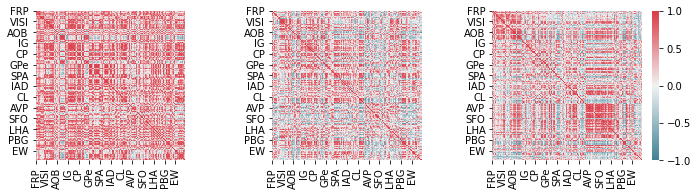

In [8]:
f, ax = plot_three_matrices(matrices=matrices_c57_with_father)
# f.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/corr_matrices_c57_wf.png',
#          dpi=300)

# c57 without father

In [9]:
matrices_c57_without_father = create_corr_matrix(
    path='dict_results/newvolumes/dict_results_across_mice_BL_woF2000_36.npy',
                              volumes=volumes)

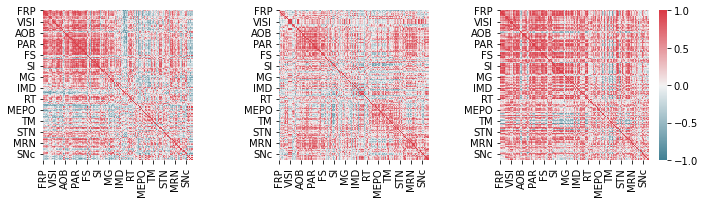

In [10]:
f, ax = plot_three_matrices(matrices=matrices_c57_without_father)
# f.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/corr_matrices_c57_wof.png',
#          dpi=300)

# WILD WITH FATHER

In [11]:
matrices_wild_with_father = create_corr_matrix(path='dict_results/dict_results_across_mice_WILD_with_father2500.npy',
                              volumes=volumes)

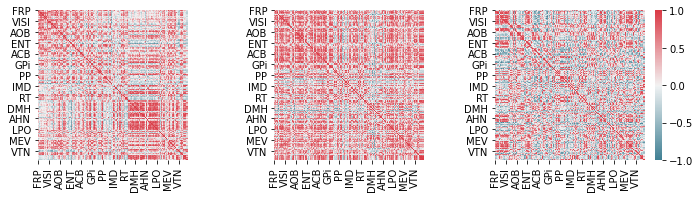

In [12]:
f, ax = plot_three_matrices(matrices=matrices_wild_with_father)
# f.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/corr_matrices_wild_wf.png',
#          dpi=300)

# WILD WITHOUT FATHER

In [13]:
matrices_wild_without_father = \
create_corr_matrix(path='dict_results/dict_results_across_mice_WILD_without_father2500.npy',
                   volumes=volumes)

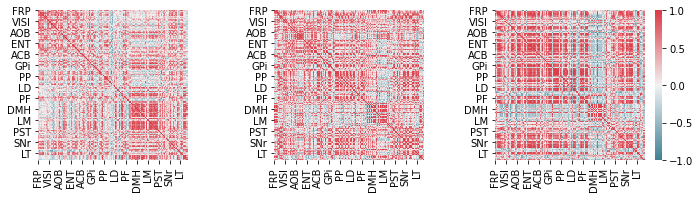

In [14]:
f, ax = plot_three_matrices(matrices=matrices_wild_without_father)
# f.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/poster_FENS/corr_matrices_wild_wof.png',
#          dpi=300)

# PISA

In [15]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_PISA_with_Pons.npy', 
                                   allow_pickle=True).item()
# reformat dictionary and subjects
old_keys = list(dict_results_across_mice.keys())
for key in old_keys:
    group = key.split('_')[-1] if key.split('_')[-1][-1]!='2' else key.split('_')[-1][:-1]
    number = key.split('_')[0]
    new_key = 'BL'+number+group
    dict_results_across_mice[new_key] = dict_results_across_mice[key]
    del dict_results_across_mice[key]
    
#remove BL12_noshock due to biased number of cells
del dict_results_across_mice['BL12noshock']
# subjects = list(dict_results_across_mice.keys())

np.save('dict_results/newvolumes/dict_results_across_mice_PISA_with_Pons_reformatted.npy',
       dict_results_across_mice)

dictionary_PISA_reformatted = np.load(
    'dict_results/newvolumes/dict_results_across_mice_PISA_with_Pons_reformatted.npy', 
                                   allow_pickle=True).item()

In [17]:
matrices_PISA_density = create_corr_matrix(
    path='dict_results/newvolumes/dict_results_across_mice_PISA_with_Pons_reformatted.npy',
    volumes=volumes,
group_labels=['noshock','demonstrator', 'observer'],
value='density')

(<Figure size 864x194.4 with 4 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

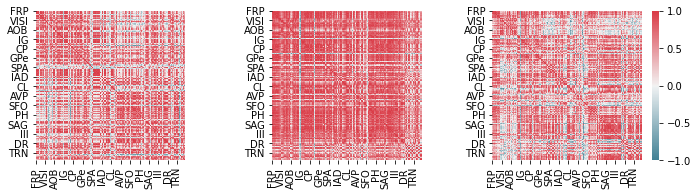

In [19]:
plot_three_matrices(matrices=matrices_PISA_density)

In [18]:
matrices_PISA_energy = create_corr_matrix(
    path='dict_results/newvolumes/dict_results_across_mice_PISA_with_Pons_reformatted.npy',
    volumes=volumes,
group_labels=['noshock','demonstrator', 'observer'],
value='energy')

(<Figure size 864x194.4 with 4 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

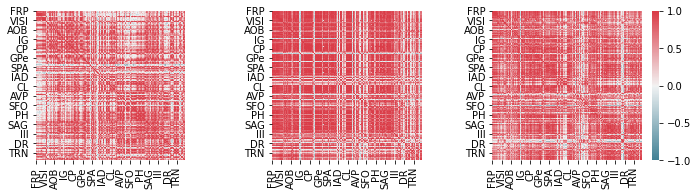

In [20]:
plot_three_matrices(matrices_PISA_energy)

# BLACK WHOLE BRAIN USV + BEDDING

In [10]:
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_BL_wf_USV_Bedding_wb.npy', 
                                   allow_pickle=True).item()

In [22]:
matrices_BL_wb_USV_Bedding_ncells = create_corr_matrix(
    path='dict_results/dict_results_across_mice_BL_wf_USV_Bedding_wb.npy',
    volumes=volumes,
    group_labels=['Control',
              'USVC57',
              'USVBALB',
              'USVC57_Bedding',
              'USVBALB_Bedding',
              'Bedding'],
    value='n_cells')

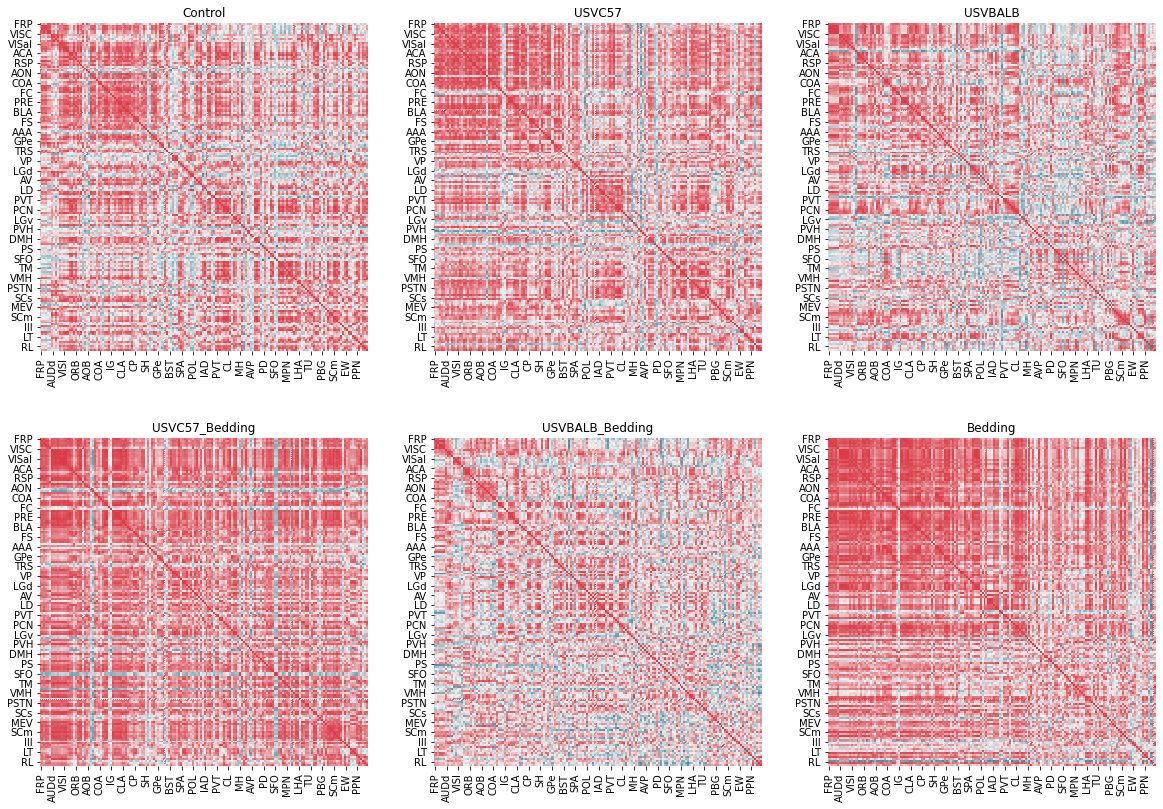

In [23]:
f, ax = plt.subplots(2,3, figsize=(20, 14))
ax = ax.flatten()
titles = ['Control',
         'USVC57',
         'USVBALB',
         'USVC57_Bedding',
         'USVBALB_Bedding',
         'Bedding']
for i, matrix in enumerate(matrices_BL_wb_USV_Bedding_ncells):
    sns.heatmap(matrix,
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        vmin=-1.0, vmax=1.0,
        square=True, cbar=False, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title(titles[i])